<h1>Operability analysis of a multistage membrane separation process for direct air capture (m-DAC) using AVEVA Process Simulation</h1>

In order to address the impacts of fossil fuel emissions to climate change, CO<sub>2</sub> capture have been expanded from usual point-source capture to CO<sub>2</sub> removal from the atmosphere. The process described in the figure simulates the use of gas separation membranes for the CO<sub>2</sub>  removal.


![m-DAC Process flow diagram](m-DAC_ProcessPFD.png)

<h2>Process Overview: Multistage Membrane-Based Direct Air Capture (DAC)</h2>
<p>
This process is designed for <strong>direct air capture (DAC) of CO<sub>2</sub></strong>, using a multistage membrane separation approach 
to concentrate carbon dioxide from atmospheric levels (~420 ppm) to a <strong>low-purity product (~5% CO<sub>2</sub> molar fraction)</strong>. 
The system is engineered to handle approximately <strong>1 megaton of air per year</strong>, aligning with urgent 
climate action goals.
</p>
<p>
The final CO<sub>2</sub>-enriched stream is suitable for applications that tolerate lower purity, such as:
<ul>
    <li>Algae cultivation</li>
    <li>Enhanced indoor farming and greenhouses</li>
    <li>Mineral carbonation processes</li>
</ul>
</p>
<p>
Key operations include vacuuming the permeate using vacuum pumps, compressors to restore pressure, and heat exchangers to maintain temperatures to acceptable ranges in order to avoid membrane degradation.
</p>

<h2>Step-by-step set up of Opyrability with AVEVA Process Simulation</h2>

<h2>Step 1: Necessary imports for connection with APS and for Operability computations:</h2>

<h4> APS connection import</h4>

In [2]:
import simcentralconnect #AVEVA PROCESS SIMULATION REQUIRED IMPORT TO ENABLE CONNECTION

<color><red><i>This import is essential to enable communication with APS. Once you have installed and configured your APS, you should be able to find the Scripting Interface files. In it, a step-by-step README file guides the user through enabling the connection.</i></color></red>

In [3]:
import numpy as np
from opyrability import AIS2AOS_map, multimodel_rep, OI_eval #Operability algorigthms import from Opyrability library
from scipy.io import savemat

# Instantiating the required interfaces for the scripting interface

sc = simcentralconnect.connect().Result
sm = sc.GetService("ISimulationManager")
vm = sc.GetService("IVariableManager")
snap = sc.GetService("ISnapshotManager")

# Example of how to set options.  API logging is ON by default.  Disabled by changing to 'false'
sc.SetOptions(repr({'Timeout': 500000, 'EnableApiLogging': 'false'}))

SimCentral.Client.Auto loaded from: C:\Program Files\SimSci\SimCentral\Scripting\DotNetFwk


<h2>Step 2: Calling the simulation file you want to work with:</h2>

In [4]:
simFile = "APS_mDAC_v4"
simName = "APS_mDAC_v4" #WARNING: Sometimes APS might rename your simulation as its opened so always make sure the name of the simulation you are working with aligns with the current opened simulation
nameSnap = "steady2" #Note: This is only required in case the user wants to set the simulation to a specific snapshot

<h2>Step 3: Function for double checking if simulation exist:</h2>

In [5]:
def open_simulation(simName):
    opened = False
    try:
        opened = sm.OpenSimulation(simName).Result         
    except System.AggregateException as ex:
        if not isinstance(ex.InnerException, System.InvalidOperationException) \
                or "simulation doesn't exists" not in ex.InnerException.Message:
            raise
    return opened



open_simulation(simName)

True

In [5]:
def variabletest():
    #vm.SetVariableValue(simName, "vac1.P", 33, "kPa").Result
    kk = vm.GetVariableValue(simName, "MDAC1.Nt").Result
    print(kk)
    vm.SetVariableValue(simName, "MDAC1.Nt",1.1e6).Result
    
variabletest()

1000000.0


<h2>Step 4: Process model function to communicate with APS and Opyrability:</h2>

In [ ]:
def M(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case - First membrane module study

    # --------- Restarting simulation snapshot before changes -----------------------------
        
    snap.RevertSnapshot(simName,nameSnap)

    #Parameters required for SetVariable method vm.SetVariableValue(<string> simulation name, <object> variable, <object> value, <object> unit, <object> apiOptions)(more on methods and interfaces is available in the AVEVA Scripting Interface documentation)
    vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result 
    vm.SetVariableValue(simName, "MDAC2.QCO2", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 

    print(f"\nCalling simulation with inputs: {u}")
    try:
        status = sm.GetSimulationStatus(simName).Result #Retrieving solution status of the simulation. Argument [2] holds the boolean value that informs if the solver was capable to solve (True) or not (False) the simulation.
        print(f"Initial simulation status: {str(status[2])}")
    except Exception as e:
        print("Failed to get simulation status:", e) 

    if (status[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
        Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result       

        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = Purity*100
        y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))
        
    else:
            # --------- Restarting solver to try again -----------------------------
        
            snap.RevertSnapshot(simName,nameSnap)

            # --------- Checking solution status again-----------------------------   
                
            status = sm.GetSimulationStatus(simName).Result

            print(u[0], u[1],"failed")
            if (status[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
                            
                # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
                
                #First membrane module study
                                
                vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result
                vm.SetVariableValue(simName, "MDAC2.QCO2", u[1], "", ).Result
            
                       
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
                Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
   
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = Purity*100
                y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))              
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study

<h2>Step 5: Defining Operability study </h2>

The current case study aims to analyze how the membrane intrinsic properties of the 1<sup>st</sup> module affect the captured CO<sub>2</sub> purity and recovery.


Calling simulation with inputs: [0. 0.]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [3.35e-08, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [7.742222222222222e-07, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [1.5149444444444445e-06, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [2.255666666666667e-06, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [2.9963888888888892e-06, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [3.7371111111111116e-06, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling simulation with inputs: [4.477833333333333e-06, 3.35e-08]
Simulation name: APS_mDAC_v3
Initial simulation status: True

Calling sim

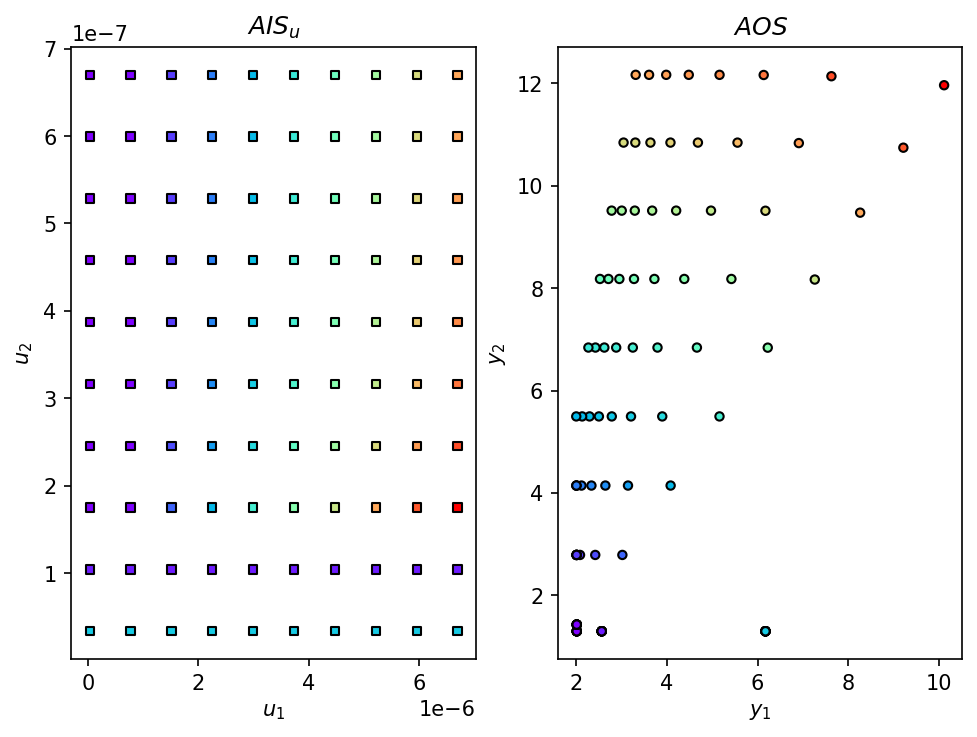

In [13]:
#---------------------- OPERABILIY STUDY --------------------------------------------------

AIS_bounds =  np.array([[3.35e-8, 6.7e-06],[3.35e-8, 6.7e-07]]) #AIS bounds definition for the 2 inputs x 2 outputs case study
#AIS_bounds =  np.array([[2220, 4123],[630, 1170]]) #AIS bounds definition for the 2 inputs x 2 outputs case study


AIS_resolution =  [10,10] #AIS discretization definition for the 2 inputs x 2 outputs case study

AIS, AOS = AIS2AOS_map(M, AIS_bounds, AIS_resolution) #Forwad mapping call for the 2 inputs x 2 outputs case study

The axes of the AIS represent different membranes, since each pair of CO<sub>2</sub> permeance (u<sub>1</sub>) and CO<sub>2</sub>/N<sub>2</sub> (u<sub>2</sub>) values physically mean that a different membrane is being evaluated.

On the other hand, the AOS axes show the outputs of the simulation. (y<sub>1</sub>) being CO<sub>2</sub> purity in mol% and (y<sub>2</sub>) being CO<sub>2</sub> recovery in %. The color gradient maps input cases to the respective outputs, and as it is possible to notice, there's seem to exist a propotional relationship between CO<sub>2</sub> purity and recovery as the membrane properties varies, showcasing the operability capabilities of assessing the process outcomes by manipulating the membrane instrinsic properties.

<h2>Multimodel representation</h2>

In [6]:
def Multi(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case - First membrane module study

    # --------- Restarting simulation snapshot before changes -----------------------------
        
    snap.RevertSnapshot(simName,nameSnap)

    #Parameters required for SetVariable method vm.SetVariableValue(<string> simulation name, <object> variable, <object> value, <object> unit, <object> apiOptions)(more on methods and interfaces is available in the AVEVA Scripting Interface documentation)
    vm.SetVariableValue(simName, "MDAC1.Nt", u[0], "", ).Result 
    vm.SetVariableValue(simName, "MDAC2.Nt", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 

    print(f"\nCalling simulation with inputs: {u}")
    try:
        status = sm.GetSimulationStatus(simName).Result #Retrieving solution status of the simulation. Argument [2] holds the boolean value that informs if the solver was capable to solve (True) or not (False) the simulation.
        print(f"Initial simulation status: {str(status[2])}")
    except Exception as e:
        print("Failed to get simulation status:", e) 

    if (status[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
        Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result       

        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = Purity*100
        y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))
        
    else:
            # --------- Restarting solver to try again -----------------------------
        
            snap.RevertSnapshot(simName,nameSnap)

            # --------- Checking solution status again-----------------------------   
                
            status = sm.GetSimulationStatus(simName).Result

            print(u[0], u[1],"failed")
            if (status[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
                            
                # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
                
                #First membrane module study
                                
                vm.SetVariableValue(simName, "MDAC1.Nt", u[0], "", ).Result
                vm.SetVariableValue(simName, "MDAC2.Nt", u[1], "", ).Result
            
                       
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
                Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
   
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = Purity*100
                y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))              
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study


Calling simulation with inputs: [800000. 150000.]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [925000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1050000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1175000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1300000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [925000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1050000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1175000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1300000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 250000.

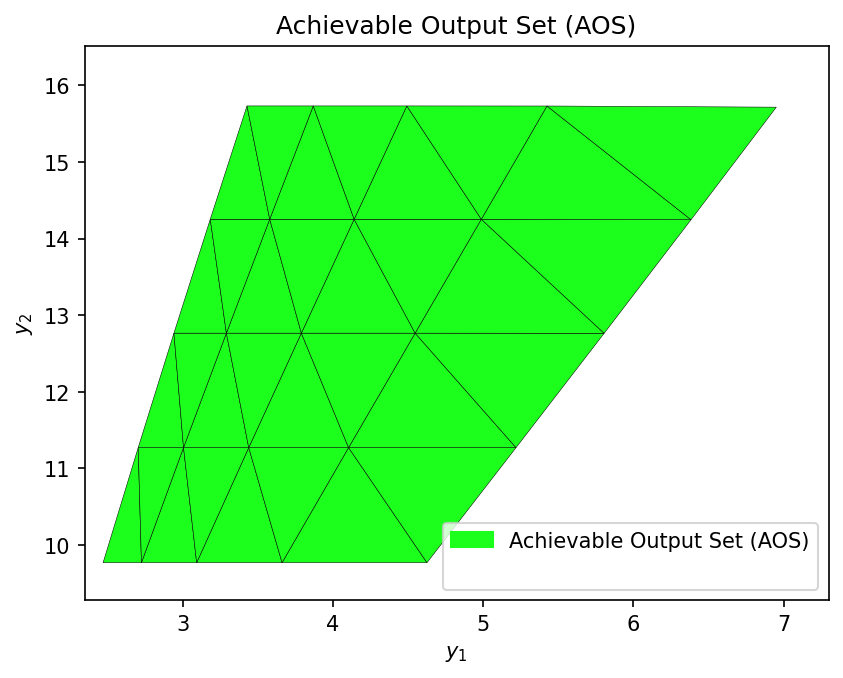

In [8]:
#---------------------- MULTIMODEL REPRESENTATION STUDY --------------------------------------------------

#AIS_bounds =  np.array([[3, 50],[3, 50]]) #AIS bounds definition for the 2 inputs x 2 outputs case study
#AIS_bounds =  np.array([[2220, 4123],[630, 1170]]) #AIS bounds definition for the 2 inputs x 2 outputs case study
AIS_bounds =  np.array([[8e5, 1.3e6],[1.5e5, 3.5e5]]) #AIS bounds definition for the 2 inputs x 2 outputs case study

AIS_resolution =  [5,5] #AIS discretization definition for the 2 inputs x 2 outputs case study

AOS_reg = multimodel_rep(Multi, AIS_bounds, AIS_resolution) #Multimodel representation call for the 2 inputs x 2 outputs case study

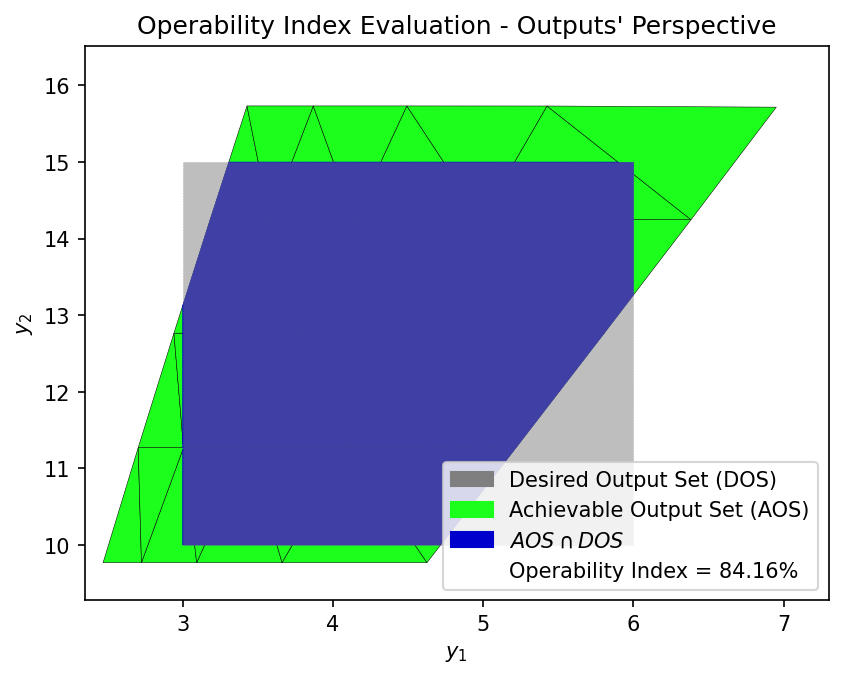

In [9]:
DOS_bounds =  np.array([[3, 6], 
                            [10, 15]])
OI = OI_eval(AOS_reg, DOS_bounds)